# PyLightcurve - Torch - Basic use

This notebook shows basic uses of ```TransitModule```class

In [1]:
import numpy as np
import torch
import importlib

import warnings
import matplotlib.pylab as plt
from pylightcurve_torch import TransitModule

plt.rcParams['figure.figsize'] = 12,3

In [2]:
def plot_model(tm, t0=True, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(tm.time.cpu().T, tm().cpu().T)
    if t0:
        ax.vlines(tm.t0.cpu().T, *ax.get_ylim(), linestyle='dashed', color='red', alpha=0.5, label='$t_0$')
        ax.legend()
    ax.set_xlabel('Time $[days]$')
    ax.set_ylabel('Normalised Flux')
    return ax

# Transit type

## Primary and/or Secondary transits fluxes

In [3]:
time =  torch.linspace(0,10,500)
pars =  {'e':0.01, 'i':90., 'w':0., 'rp': 0.05, 'method': 'linear', 'ldc': [0.1], 
             'P': 4., 't0': 5., 'a': 5., 'fp': 0.0001}

By default only primary transit is computed by __call__ / forward method

Text(0.5, 1.0, 'primary transit only')

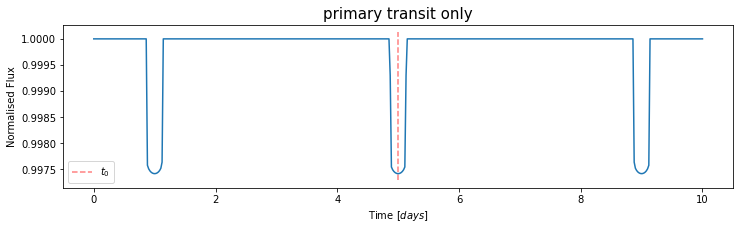

In [4]:
tm = TransitModule(time, **pars)

plot_model(tm)
plt.title("primary transit only", fontsize=15)

Secondary eclipse computation can be activated with ```secondary=True```

Text(0.5, 1.0, 'primary and secondary transits')

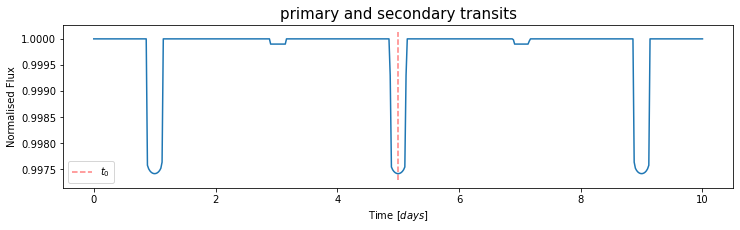

In [5]:
tm = TransitModule(time, secondary=True, **pars)

plot_model(tm)
plt.title("primary and secondary transits", fontsize=15)

For eclipse computation only, specify ```primary=False```

Text(0.5, 1.0, 'secondary transit only')

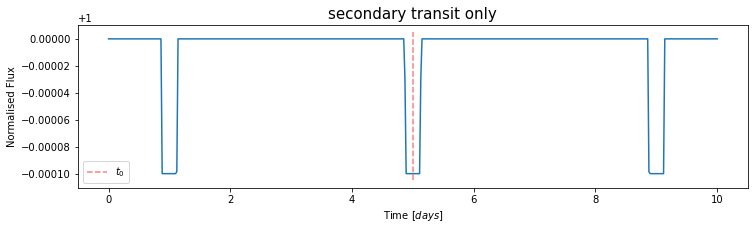

In [6]:
tm = TransitModule(time, primary=False, secondary=True, **pars)

plot_model(tm)
plt.title("secondary transit only", fontsize=15)

Note that in this case the mid transit epoch parameter ```t0``` is interpreted as the secondary transit epoch.

This can be avoided using ```epoch_type='primary'``` or enforced using ```epoch_type='secondary'```

Text(0.5, 1.0, "epoch_type='primary'")

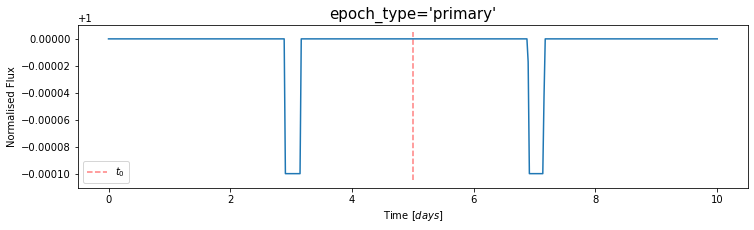

In [7]:
tm = TransitModule(time, primary=False, secondary=True, epoch_type='primary', **pars)

plot_model(tm)
plt.title("epoch_type='primary'", fontsize=15)

Text(0.5, 1.0, "epoch_type='secondary'")

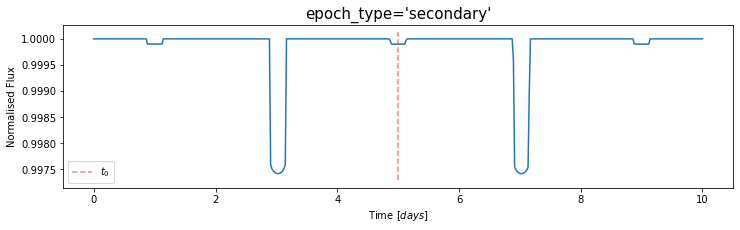

In [8]:
tm = TransitModule(time, secondary=True, epoch_type='secondary', **pars)

plot_model(tm)
plt.title("epoch_type='secondary'", fontsize=15)

# batches of inputs

## multiple parameters

In [9]:
pars = {'e': 0.1, 'i':90., 'w': 0.2, 'rp': 0.1, 'method': 'linear', 'ldc': [0.1], 
             'P': 10., 't0': 5., 'a': 5., 'fp': 0.0001}
time =  torch.linspace(4,6,500)

tm = TransitModule(time, **pars)

Any parameter can be changed to a vectorised one.
Here is an example with one parameter at at time

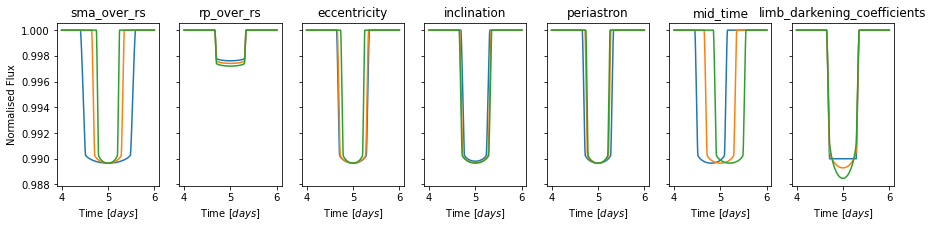

In [10]:
fig, ax = plt.subplots(1, 7, figsize=(15,3), sharey=True)

tm = TransitModule(time, **pars)
tm.set_param('a', (3,5,7))
plot_model(tm, ax=ax[0], t0=False)
ax[0].set_title('sma_over_rs')

tm = TransitModule(time, **pars)

tm.set_param('rp', (0.048, 0.05, 0.052))
plot_model(tm, ax=ax[1], t0=False)
ax[1].set_ylabel('')
ax[1].set_title('rp_over_rs')

tm = TransitModule(time, **pars)
tm.set_param('e', (0., 0.3, 0.7))
plot_model(tm, ax=ax[2], t0=False)
ax[2].set_ylabel('')
ax[2].set_title('eccentricity')

tm = TransitModule(time, **pars)
tm.set_param('i', (84,87,90))
plot_model(tm, ax=ax[3], t0=False)
ax[3].set_ylabel('')
ax[3].set_title('inclination')

tm = TransitModule(time, **pars)
tm.set_params(w=(0, 45, 90), e=0.3)
plot_model(tm, ax=ax[4], t0=False)
ax[4].set_ylabel('')
ax[4].set_title('periastron')

tm = TransitModule(time, **pars)
tm.set_param('t0', (4.8, 5, 5.2))
plot_model(tm, ax=ax[5], t0=False)
ax[5].set_ylabel('')
ax[5].set_title('mid_time')

tm = TransitModule(time, **pars)
tm.set_param('ldc', [[0.], [0.2], [0.4]])
plot_model(tm, ax=ax[6], t0=False)
ax[6].set_ylabel('')
ax[6].set_title('limb_darkening_coefficients')

plt.subplots_adjust(wspace=None)

...and with every parameters together:

<AxesSubplot:xlabel='Time $[days]$', ylabel='Normalised Flux'>

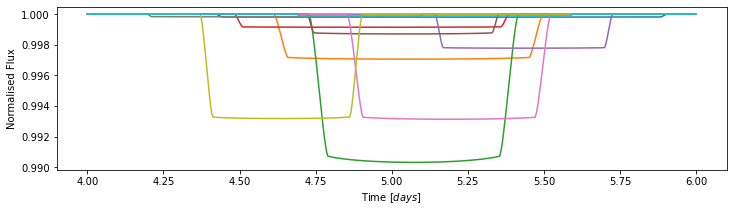

In [11]:
N = 10
tm = TransitModule(time, **pars)
tm.set_param('a', np.random.rand(N) * 5 + 2)
tm.set_param('rp', np.random.rand(N) / 10)
tm.set_param('t0', np.random.normal(5,0.2,N))
tm.set_param('ldc', np.random.rand(N) / 10)
plot_model(tm, t0=False)

## multiple time vectors

In [12]:
N = 10
time = torch.linspace(0,2,500)[None, :].repeat(N,1) + torch.linspace(3.5,5,N)[:,None]
tm = TransitModule(time, **pars)
tm

TransitModule(primary=True, shape=(10, 500))

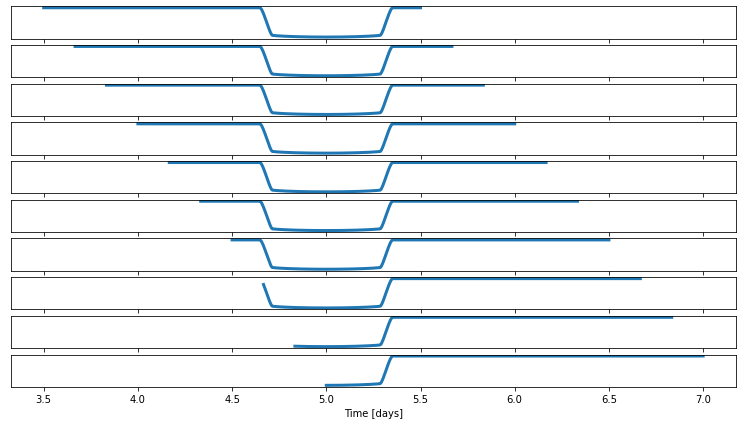

In [13]:
_, ax = plt.subplots(N, 1, figsize=(13,7), sharex=True)
for i, x in enumerate(tm()):
    ax[i].plot(time[i], x, linewidth=3)
    ax[i].set_yticks([])
plt.xlabel('Time [days]')
plt.subplots_adjust(hspace=None)

# Parameters flexibility

Although providing the transit parameters is necessary for computing the flux drops caused by the transits, they can be given and changed in variable ways.


## Missing params

A RuntimeError will be raised if one or several necessary parameters are missing

In [14]:
tm = TransitModule(time=range(10))
try:
    tm()
except RuntimeError as e:
    print(e)

Parameter 'a' should not be missing


only arguments necessary for called methods need to be defined

In [15]:
tm.set_params(P=10, i=90, e=0, a=5, t0=5, w=5)
tm.get_position()
print('no exception raised')

no exception raised


## Class attributes
Parameters can be provided as ```TransitModule``` attributes when initialising an instance. 

In [16]:
pars = {'e':0.01, 'i':90., 'w':0., 'rp': 0.05, 'method': 'linear', 
         'ldc': 0.1, 'P': 10., 't0': 5., 'a': 5., 'fp': 0.0001}

In [17]:
tm = TransitModule(time=range(10), **pars)

tm()    

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9974, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)

...or by using the ```set_param```dedicated method later on. 

In [18]:
tm = TransitModule(time=range(10))
tm.set_params(**pars)
tm()    

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9974, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64)

## Method external inputs

Transit parameters can alternatively be passed directly while calling the methods which compute the orbit, duration, or flux drops.

Unless specified otherwise, these externally provided arguments will undergo the same type, shape and dtype preparation as method attributes before being fed into functions

In [19]:
tm = TransitModule(time=range(10))

tm(**pars)
assert tm.rp is None and tm.t0 is None

/Users/mario/git-repos/pylightcurve-torch/pylightcurve_torch/nn.py:323: UserWarning: Neither of method nor ldc shape seem to provide a clear ldc dimensionality.It is advised to provide either method str arg or 2D-shaped ldc inputs
  warnings.warn("Neither of method nor ldc shape seem to provide a clear ldc dimensionality."


the call to ```get_flux_drop``` didn't raise any exception although the module's attributes are None.

A mix of defined attributes parameters and method argument can correctly be used, with in that case priority given to the external argument if conflict

In [20]:
tm = TransitModule(time=range(10), **pars)

tm(rp=[3,4]).shape

torch.Size([2, 10])

The shape of the transit module won't change because of external arguments:

In [21]:
tm.shape

(1, 10)